In [59]:
# inversion calculation

In [60]:
# to display plots in notebook
%matplotlib inline
%config InlineBackend.figure_format = "retina"

from matplotlib import rcParams
rcParams["savefig.dpi"] = 300  # high res plots
rcParams["font.size"] = 12

import warnings
warnings.filterwarnings('ignore')

In [61]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import re
import cartopy.crs as ccrs
import pandas as pd
from gamap_colormap import WhGrYlRd  # import the "WhGrYlRd" variable from my custom Python script

In [62]:
name_month = 'May' # Jan, Feb, Mar
imonth     =  5    # 1,2,3
mode       = 'N'  # 'N': Nadir or 'NG': Nadir + Glint

In [63]:
input_directory = '/geos/u73/msadiq/GEOS-Chem/analysis/python/data/'
output_directory = input_directory

if mode == 'N':
    delta_y0_file = 'delta_y0_model_N_' + name_month + '.nc'
    xco2_file = 'XCO2_mod_and_oco2_N_' + name_month + '.nc'
else:
    delta_y0_file = 'delta_y0_model_' + name_month + '.nc'
    xco2_file = 'XCO2_mod_and_oco2_' + name_month + '.nc'

In [64]:
ds_delta_y0 = xr.open_dataset(input_directory + delta_y0_file)
varnames = list(ds_delta_y0.data_vars.keys())

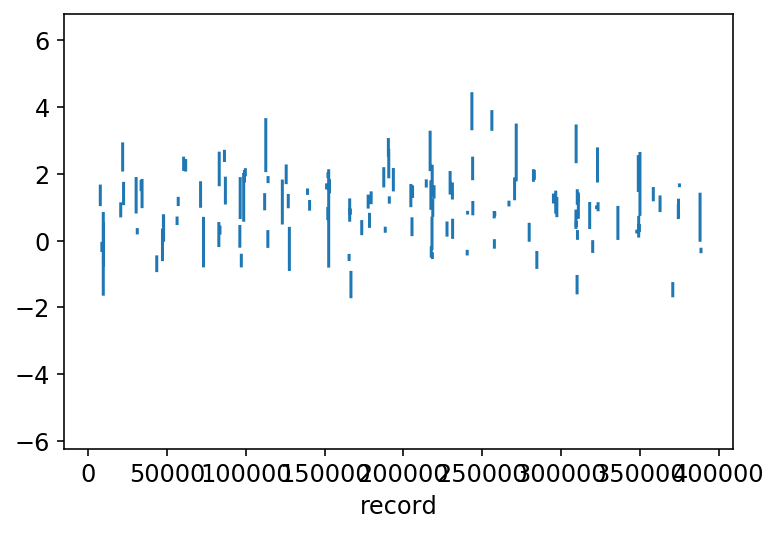

In [65]:
ds_xco2 = xr.open_dataset(input_directory + xco2_file)
diff = ds_xco2['xco2_oco2'] - ds_xco2['xco2_model']
diff.plot()

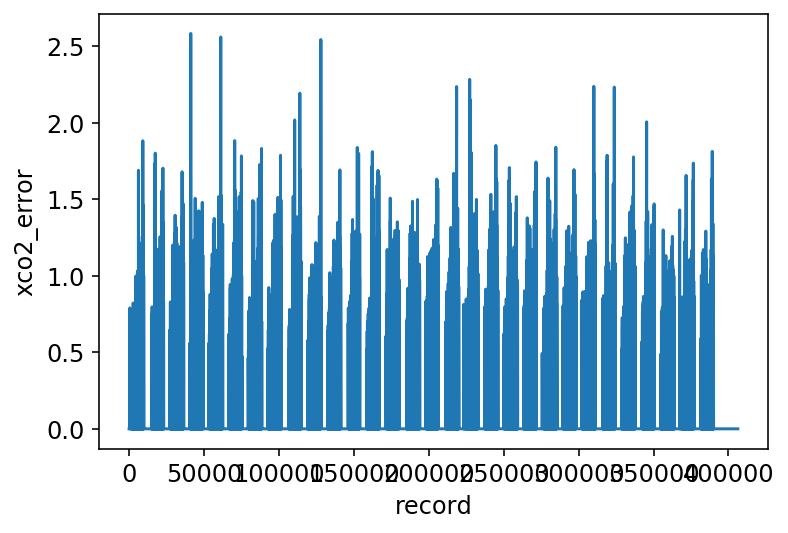

In [66]:
xco2_error = ds_xco2['xco2_error']
xco2_error.plot()

In [67]:
# reduce the size of all arrays and matrices, from 400k to <10k
xco2_oco2 = ds_xco2['xco2_oco2']
x = xco2_oco2.copy()
x = x[np.logical_not(np.isnan(x))]
ind = x.record.values # index for slicing
length = len(ind)
length

1554

(1554,)


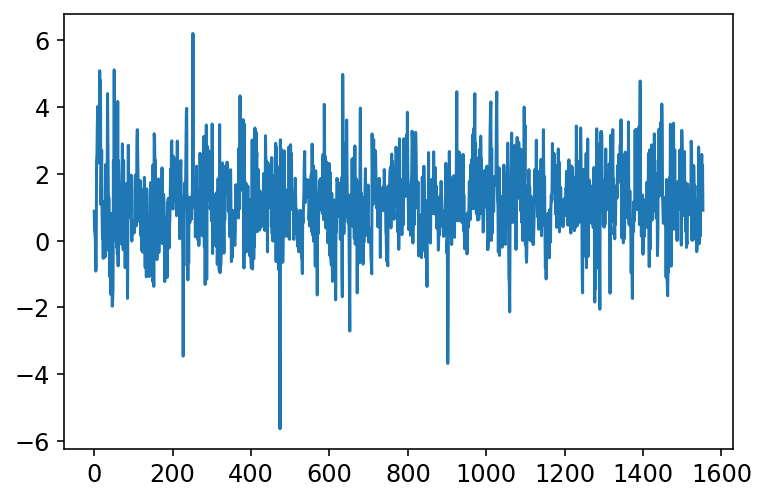

In [68]:
diff_slice = diff[ind].values
print(np.shape(diff_slice))
plt.plot(diff_slice) # same as above, excluded nan values

1554


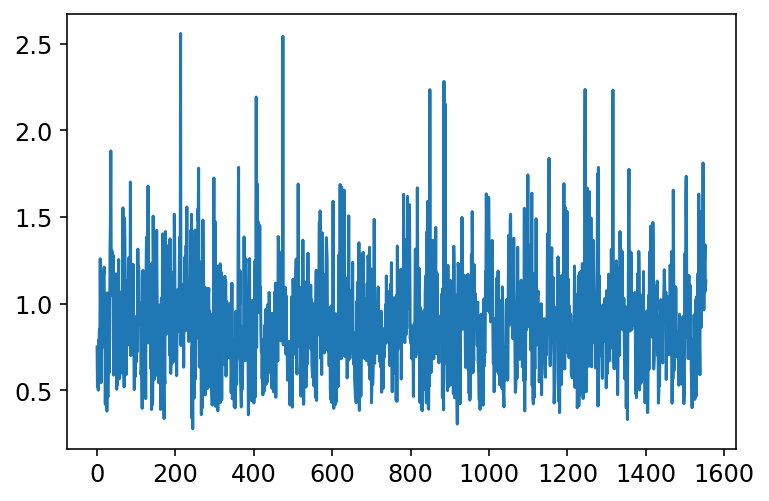

In [69]:
xco2_error_slice = xco2_error[ind].values
print(len(xco2_error_slice))
plt.plot(xco2_error_slice) # same as above, excluded nan values

In [70]:
del_Y_matrix = np.empty((length,22))
del_Y_matrix[:] = np.nan
print(np.shape(del_Y_matrix))

for itag in range(22):
    name_var = 'X_SpeciesConc_CO2Tag' + str(itag+1)
    del_Y_matrix[:,itag] = ds_delta_y0[name_var][ind].values

(1554, 22)


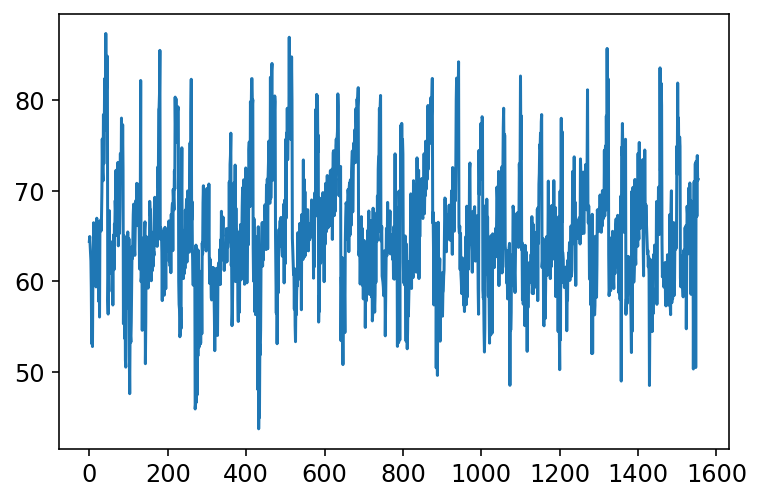

In [71]:
plt.plot(del_Y_matrix[:,5])

In [72]:
del_Y_tran = np.matrix.transpose(del_Y_matrix)
first = np.matmul(del_Y_matrix,del_Y_tran)
print(np.shape(first))
first

(1554, 1554)


array([[ 91243.76683722,  92006.14256874,  90729.02789897, ...,
        104609.70853055, 100788.30575959, 100956.96439956],
       [ 92006.14256874,  92774.88823457,  91487.10279571, ...,
        105483.7617175 , 101630.42970079, 101800.49754667],
       [ 90729.02789897,  91487.10279571,  90217.19279123, ...,
        104019.56756082, 100219.72269888, 100387.42987467],
       ...,
       [104609.70853055, 105483.7617175 , 104019.56756082, ...,
        119933.66411543, 115552.41705634, 115745.77987412],
       [100788.30575959, 101630.42970079, 100219.72269888, ...,
        115552.41705634, 111331.36341599, 111517.65413033],
       [100956.96439956, 101800.49754667, 100387.42987467, ...,
        115745.77987412, 111517.65413033, 111704.26071463]])

In [73]:
obs_error = np.zeros((length,length))
print(np.shape(obs_error))
for idiag in range(length):
    obs_error[idiag, idiag] = xco2_error_slice[idiag]**2 + 2.5 #random_error[idiag]
obs_error

(1554, 1554)


array([[3.0637276 , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 2.77181753, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 2.90539968, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 4.29709238, 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 3.65320331,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        3.78290335]])

In [74]:
second = np.linalg.inv(first+obs_error)
second

array([[ 3.26043039e-01, -3.97382737e-04, -3.73511185e-04, ...,
        -1.92011222e-05, -1.52103901e-04, -1.55142816e-04],
       [-3.97382738e-04,  3.60331392e-01, -4.16197587e-04, ...,
        -2.17200297e-05, -1.69995916e-04, -1.73502769e-04],
       [-3.73511187e-04, -4.16197586e-04,  3.43795356e-01, ...,
        -2.08945584e-05, -1.60508998e-04, -1.63955340e-04],
       ...,
       [-1.92011216e-05, -2.17200293e-05, -2.08945575e-05, ...,
         2.31684167e-01, -1.09633850e-04, -9.57936453e-05],
       [-1.52103901e-04, -1.69995917e-04, -1.60508998e-04, ...,
        -1.09633851e-04,  2.72772394e-01, -1.03278587e-03],
       [-1.55142816e-04, -1.73502769e-04, -1.63955341e-04, ...,
        -9.57936460e-05, -1.03278587e-03,  2.63179340e-01]])

In [75]:
third = np.matmul(del_Y_tran,second)
print(np.shape(third))
third

(22, 1554)


array([[ 9.30725733e-04,  8.19950117e-04,  4.79731656e-04, ...,
        -1.29212425e-03, -1.70245724e-03, -2.13544250e-03],
       [ 4.33870574e-04,  4.99811624e-04,  4.91738991e-04, ...,
        -1.16044444e-03, -1.44531880e-03, -1.87405196e-03],
       [-1.03768870e-06,  1.61961770e-05,  3.83007730e-05, ...,
        -1.18932741e-03, -1.53314153e-03, -1.89751579e-03],
       ...,
       [ 2.23887038e-04,  2.63333610e-04,  2.66218359e-04, ...,
        -1.27181080e-03, -8.06279378e-04, -1.18439842e-03],
       [ 1.72170899e-03,  1.93696836e-03,  1.84625394e-03, ...,
        -1.36715816e-03,  1.44900752e-03,  1.45236713e-03],
       [ 1.34299856e-03,  1.51530558e-03,  1.44998497e-03, ...,
        -3.34916824e-05,  1.71689958e-03,  2.38396913e-03]])

In [76]:
del_X_f = np.zeros((22,22))
for idiag in range(22):
    del_X_f[idiag,idiag] = 1.0  #/21 # GrC/yr
del_X_f_inv = np.linalg.inv(del_X_f)

In [77]:
k_e = np.matmul(del_X_f,third)
print(np.shape(k_e))
k_e

(22, 1554)


array([[ 9.30725733e-04,  8.19950117e-04,  4.79731656e-04, ...,
        -1.29212425e-03, -1.70245724e-03, -2.13544250e-03],
       [ 4.33870574e-04,  4.99811624e-04,  4.91738991e-04, ...,
        -1.16044444e-03, -1.44531880e-03, -1.87405196e-03],
       [-1.03768870e-06,  1.61961770e-05,  3.83007730e-05, ...,
        -1.18932741e-03, -1.53314153e-03, -1.89751579e-03],
       ...,
       [ 2.23887038e-04,  2.63333610e-04,  2.66218359e-04, ...,
        -1.27181080e-03, -8.06279378e-04, -1.18439842e-03],
       [ 1.72170899e-03,  1.93696836e-03,  1.84625394e-03, ...,
        -1.36715816e-03,  1.44900752e-03,  1.45236713e-03],
       [ 1.34299856e-03,  1.51530558e-03,  1.44998497e-03, ...,
        -3.34916824e-05,  1.71689958e-03,  2.38396913e-03]])

In [78]:
adjust = np.matmul(k_e, diff_slice)
adjust

array([-0.90971863, -0.61911921, -0.95270939,  0.16142037,  0.59335695,
        0.886747  ,  0.04884902, -0.38751682, -0.37450621, -0.52525912,
       -0.70460946,  0.25071384,  0.14373341,  1.09392015,  1.57195783,
       -0.49090704,  0.08896366,  0.47656099,  0.00722302,  0.37981351,
       -0.38090665, -0.34283852])

In [79]:
df = pd.read_csv(input_directory + 'base_emission.csv')
region_names = df['name'].values
prior_emission = df['emission'].values

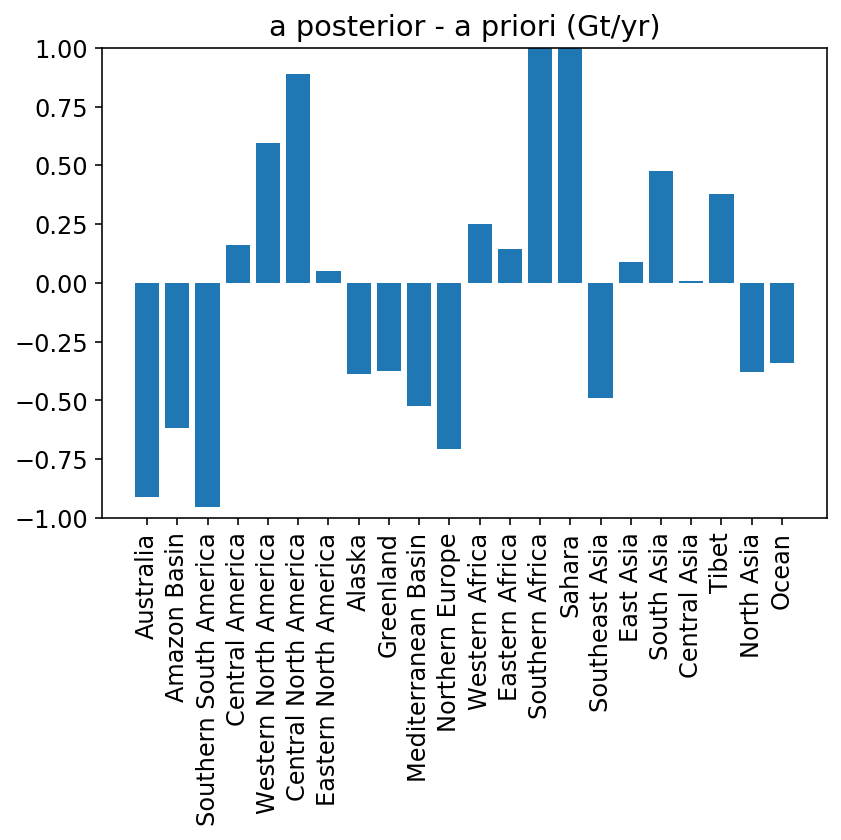

In [80]:
# first attempt
fig = plt.figure(figsize=[6, 6])
plt.bar(region_names, adjust)
plt.ylim(top   = 1,bottom = -1)
plt.title('a posterior - a priori (Gt/yr)')
plt.xticks(rotation=90)
fig.tight_layout()

fig.savefig(output_directory+'adjustment_' + name_month +'.png', dpi=300)

shape of k_e:  (22, 1554)


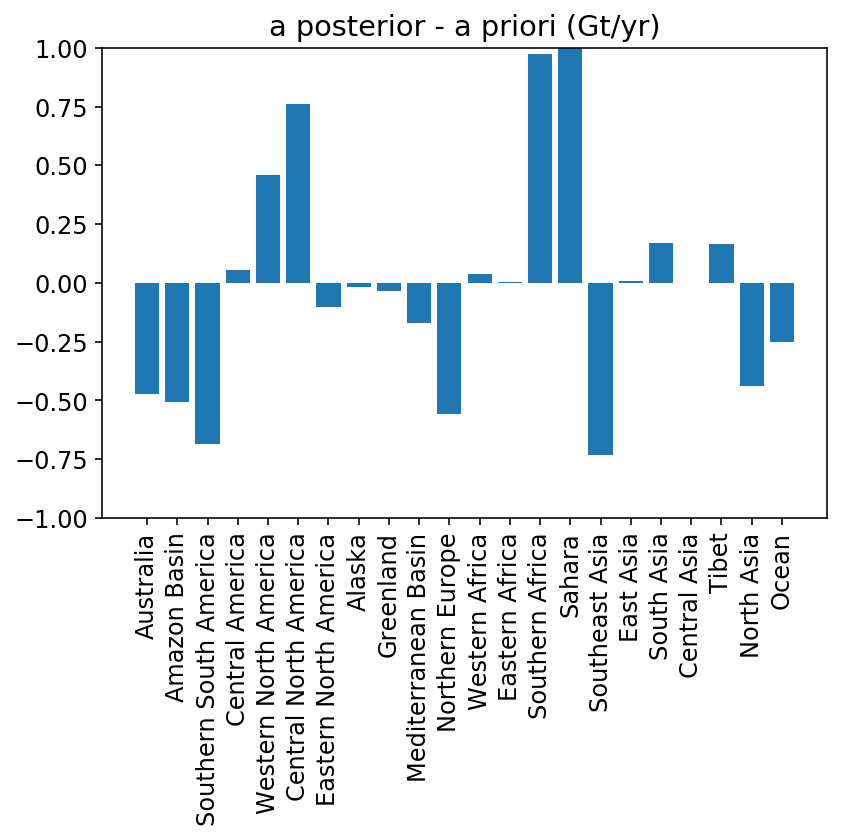

In [86]:
# different algorithm
X_f = np.zeros((22,22))
for idiag in range(22):
    X_f[idiag,idiag] = prior_emission[idiag]
mul1 = np.matmul(del_X_f_inv, X_f)
del_Y = np.matmul(del_Y_matrix, mul1)
Y_tran = np.matrix.transpose(del_Y)
first = np.matmul(del_Y,Y_tran)
second = np.linalg.inv(first+obs_error)
third = np.matmul(Y_tran,second)
k_e = np.matmul(del_X_f,third)
print('shape of k_e: ', k_e.shape)
adjust = np.matmul(k_e, diff_slice)

fig = plt.figure(figsize=[6, 6])
plt.bar(region_names, adjust)
plt.ylim(top   = 1,bottom = -1)
plt.title('a posterior - a priori (Gt/yr)')
plt.xticks(rotation=90)
fig.tight_layout()

fig.savefig(output_directory+'adjustment_' + name_month +'.png', dpi=300)

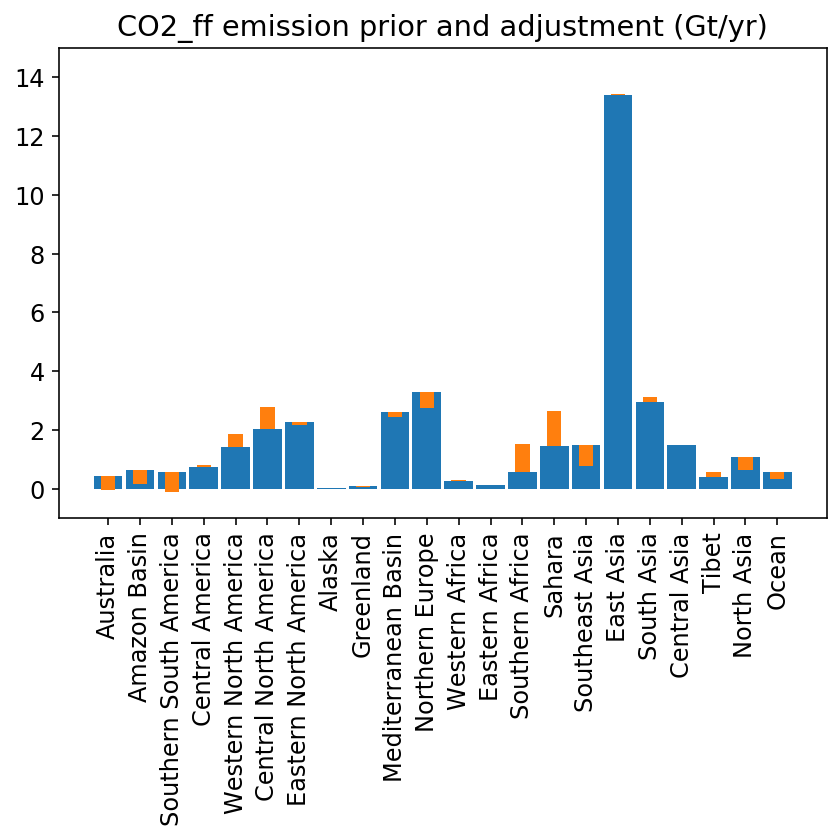

In [87]:
fig = plt.figure(figsize=[6, 6])
width = 0.9
plt.bar(region_names, prior_emission, width)
plt.bar(region_names, adjust,         width*0.5, bottom = prior_emission)
plt.ylim(top   = 15,bottom = -1)
plt.title('CO2_ff emission prior and adjustment (Gt/yr)')
plt.xticks(rotation=90)
fig.tight_layout()

fig.savefig(output_directory+'posterior_' + name_month +'.png', dpi=300)